# Climate-Friendly Food Systems (CFFS) Labelling Project

### The University of British Columbia

***

## Part V: Labelling Recipes

## Set up and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
from configparser import ConfigParser

In [2]:
# RUN ONLY ONCE
# os.chdir is used to change the current directory to the specified path
os.chdir("../") # Sets path to the repo folder as it is one level above where this file exists!
path = os.getcwd()
print(path)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024


## Set Baselines

Make sure to run ```Label_Baseline_Calculation/baseline_OK.ipynb``` if there is a change in the baseline calculation or if a new parameter is added, update accordingly.

In [3]:
config = ConfigParser()
config.read("data/Misc/data_for_calculating_baseline/baseline.ini")

overall_baseline = float(config["baseline"]["GHG_baseline"])
fifty_cutoff = overall_baseline/2

GHG_baseline = float(config["baseline"]["GHG_baseline"])
nitrogen_baseline = float(config["baseline"]["nitrogen_baseline"])
water_baseline = float(config["baseline"]["water_baseline"])
land_baseline = float(config["baseline"]["land_baseline"])
print(GHG_baseline,nitrogen_baseline,water_baseline,land_baseline)

364.61114734025256 4.428944853430558 1320.569404551064 0.8534548672606304


In [4]:
# CHANGE THIS AS NEEDED:
# restaurant_name = "OK24-25"
# restaurant_name = "Gather24-25"
# restaurant_name = "Totem24-25"
restaurant_name = "HARVEST_FESTIVAL"

In [5]:
def create_ghg_label(label):
    # determine the GHG label based on the given label value and predefined cutoffs
    if label > overall_baseline:
        # if the label value is > than overall baseline, assign "Red" label
        return "Red"
    elif (label <= overall_baseline) & (label > fifty_cutoff):
        # if the label value is between overall baseline and fifty_cutoff, assign "Yellow" label
        return "Yellow"
    elif label <= fifty_cutoff:
        # if the label value is less than or equal to the fifty_cutoff, assign "Green" label
        return "Green"


In [6]:
def create_results_all_factors(df):
    # create a Combined Label based on different factors for each row in the DataFrame
    df["Combined Label"] = ""

    # add another parameter: n so that change the number of factors instead of multiplying by 3

    def calculate_all_factors(ghg, nitrogen, water, land):
        # calculate the combined label value based on the given factors
        weighted_ghg = ghg / (4 * GHG_baseline)
        weighted_nitrogen = nitrogen / (4 * nitrogen_baseline)
        weighted_water = water / (4 * water_baseline)

        # most recently added
        weighted_land = land / (4 * land_baseline)

        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land


    for ind, row in df.iterrows():
        # iterate over each row in the DataFrame and calculate the combined label
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"],
                                      row['Land Use (m^2) / 100g'])

        if label <= 0.5:
            # if the label value is less than or equal to 0.5, assign "Green" label
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            # if the label value is greater than or equal to 1, assign "Red" label
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            # if the label value is between 0.5 and 1, assign "Yellow" label
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


In [7]:
def add_menu_names(df, dict):
    # add menu names to the DataFrame based on a dictionary
    df["Displayed Name"] = ""
    menu_name = list(dict.keys())
    menu_ID = list(dict.values())
    for ind, row in df.iterrows():
        searchID = row["ProdId"]
        if searchID in menu_ID:
            # if the product ID is found in the menu_ID list, retrieve the corresponding name
            position = menu_ID.index(searchID)
            name = menu_name[position]
            df.loc[ind, "Displayed Name"] = name
        else:
            continue
    name_col = df.pop("Displayed Name")
    df.insert(0, "Displayed Name", name_col)
    df = df.dropna(subset=["Displayed Name"])

    df_temp = df["Displayed Name"].str.split("|", expand=True)
    df["Category"] = df_temp[0]
    df["Displayed Name"] = df_temp[1]
    name_col2 = df.pop("Category")
    df.insert(0, "Category", name_col2)
    # returns the modified DataFrame with the added "Category" and "Displayed Name" columns
    return df


In [8]:
def create_final_counts(df):
    # create final counts of GHG and combined labels from DataFrame

    # count the occurrences of GHG Only labels
    ghg_red = df["GHG Only Label"].value_counts()["Red"]
    ghg_yellow = df["GHG Only Label"].value_counts()["Yellow"]
    ghg_green = df["GHG Only Label"].value_counts()["Green"]
    # count the occurrences of Combined labels
    all_red = df["Combined Label"].value_counts()["Red"]
    all_yellow = df["Combined Label"].value_counts()["Yellow"]
    all_green = df["Combined Label"].value_counts()["Green"]
    print(all_red, all_yellow, all_green)
    # create a dictionary to store the label counts
    data = {"GHG Label Counts": [ghg_red, ghg_yellow, ghg_green],
            "Combined Label Counts": [all_red, all_yellow, all_green]}
    # create a DataFrame from the label counts data and return it
    results = pd.DataFrame(data, index=["Red", "Yellow", "Green"])
    return results


In [9]:
def create_visualizations(df):
    df.reset_index(inplace=True)
    df = df.rename(columns={"index": "Color"})
    sns.set_theme(style="darkgrid")
    palette = {"Green": "tab:green", "Red": "tab:red", "Yellow": "tab:orange", "Sum": "tab:blue"}
    fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=False, sharey=True)
    fig.suptitle("Emission Label Counts")
    ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
    ax1.set_title("GHG Emission Label")
    ax1.set_ylabel("Counts")
    ax1.set_xlabel("")
    ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)
    ax2.set_title("Combined Emissions Label")
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    fig.title = "Color Comparison"
    ax1.set_title = "GHG Emission Label Counts"
    ax2.set_title = "Combined Emissions Label Counts"
    ax2.set_ylabel = ""
    for ax in [ax1, ax2]:
        for i in ax.containers:
            ax.bar_label(i, )
    plt.tight_layout()
    plt.savefig(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/" + restaurant_name + "Summary_fig.png")
    plt.show()

In [10]:
def create_category_true(df):
    # create category columns for True values in the DataFrame

    # create empty columns for each category
    df["RED"] = ""
    df["YELLOW"] = ""
    df["GREEN"] = ""
    # iterate over each row in the DataFrame
    for ind, row in df.iterrows():
        # Check the value of the Combined Label column and assign "TRUE" to the corresponding category column
        if row["Combined Label"] == "Red":
            df.loc[ind, "RED"] = "TRUE"
        if row["Combined Label"] == "Yellow":
            df.loc[ind, "YELLOW"] = "TRUE"
        if row["Combined Label"] == "Green":
            df.loc[ind, "GREEN"] = "TRUE"
    # adds category columns for True values based on the Combined Label column
    return df


In [11]:
products = pd.read_csv(os.path.join(os.getcwd(), "data", "final", "Recipes Footprints.csv"))

In [12]:
final = products.copy()
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-73975,HARVEST Feastival 2024,FOOD,470.915000,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,1.000000,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,1.000000,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1110.545455,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1119.000000,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49
5,R-62998,HARVEST|Muffin|Seasonal (6ea),FOOD - BAKERY & DESSERTS,1056.000000,1598.625000,15.540000,5.134500,440.16,13462.78,151.38,1.47,41.68,1274.88,0.49
6,R-62877,HARVEST|Muffin|Vegan (6ea),FOOD - BAKERY & DESSERTS,500.000000,761.250000,7.400000,2.445000,209.60,6410.85,152.25,1.48,41.92,1282.17,0.49
7,R-62875,HARVEST|Pot|B.berry Chia Parfa,FOOD - BAKERY & DESSERTS,198.000000,480.269724,0.875736,0.526862,121.67,7707.34,242.56,0.44,61.45,3892.60,0.27
8,R-62874,HARVEST|Pot|Chia Pudding,CK - FOOD,180.000000,191.919000,0.702825,0.371719,51.31,2501.13,106.62,0.39,28.51,1389.52,0.21
9,R-37215,HARVEST|Pot|Overnight Oat,CK - FOOD,210.000000,275.543450,0.857275,0.512242,69.63,3736.69,131.21,0.41,33.16,1779.38,0.24


In [13]:
final["GHG Only Label"] = final["GHG Emission (g) / 100g"].apply(lambda x: create_ghg_label(x))
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label
0,R-73975,HARVEST Feastival 2024,FOOD,470.915000,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42,Yellow
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,1.000000,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52,Yellow
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,1.000000,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52,Yellow
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1110.545455,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47,Green
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1119.000000,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49,Green
5,R-62998,HARVEST|Muffin|Seasonal (6ea),FOOD - BAKERY & DESSERTS,1056.000000,1598.625000,15.540000,5.134500,440.16,13462.78,151.38,1.47,41.68,1274.88,0.49,Green
6,R-62877,HARVEST|Muffin|Vegan (6ea),FOOD - BAKERY & DESSERTS,500.000000,761.250000,7.400000,2.445000,209.60,6410.85,152.25,1.48,41.92,1282.17,0.49,Green
7,R-62875,HARVEST|Pot|B.berry Chia Parfa,FOOD - BAKERY & DESSERTS,198.000000,480.269724,0.875736,0.526862,121.67,7707.34,242.56,0.44,61.45,3892.60,0.27,Yellow
8,R-62874,HARVEST|Pot|Chia Pudding,CK - FOOD,180.000000,191.919000,0.702825,0.371719,51.31,2501.13,106.62,0.39,28.51,1389.52,0.21,Green
9,R-37215,HARVEST|Pot|Overnight Oat,CK - FOOD,210.000000,275.543450,0.857275,0.512242,69.63,3736.69,131.21,0.41,33.16,1779.38,0.24,Green


In [14]:
final = create_results_all_factors(final)
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,R-73975,HARVEST Feastival 2024,FOOD,470.915000,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42,Yellow,Yellow
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,1.000000,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52,Yellow,Red
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,1.000000,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52,Yellow,Yellow
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1110.545455,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47,Green,Yellow
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1119.000000,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49,Green,Yellow
5,R-62998,HARVEST|Muffin|Seasonal (6ea),FOOD - BAKERY & DESSERTS,1056.000000,1598.625000,15.540000,5.134500,440.16,13462.78,151.38,1.47,41.68,1274.88,0.49,Green,Yellow
6,R-62877,HARVEST|Muffin|Vegan (6ea),FOOD - BAKERY & DESSERTS,500.000000,761.250000,7.400000,2.445000,209.60,6410.85,152.25,1.48,41.92,1282.17,0.49,Green,Yellow
7,R-62875,HARVEST|Pot|B.berry Chia Parfa,FOOD - BAKERY & DESSERTS,198.000000,480.269724,0.875736,0.526862,121.67,7707.34,242.56,0.44,61.45,3892.60,0.27,Yellow,Red
8,R-62874,HARVEST|Pot|Chia Pudding,CK - FOOD,180.000000,191.919000,0.702825,0.371719,51.31,2501.13,106.62,0.39,28.51,1389.52,0.21,Green,Green
9,R-37215,HARVEST|Pot|Overnight Oat,CK - FOOD,210.000000,275.543450,0.857275,0.512242,69.63,3736.69,131.21,0.41,33.16,1779.38,0.24,Green,Yellow


In [15]:
final.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".csv", 
             index=False)
final.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".xlsx", 
               sheet_name="Labels", index=False)

In [16]:
# CHANGE THE NAME AS NEEDED AS PER THE RESTAURANT:

OK_list = final.set_index('Description')['ProdId'].to_dict()
OK_list

{'HARVEST Feastival 2024': 'R-73975',
 'HARVEST|Cake|Granola Bar 6ea': 'R-62876',
 'HARVEST|Cake|Ponderosa 6ea': 'R-33249',
 'HARVEST|Muffin|Carrot (6ea)': 'R-63503',
 'HARVEST|Muffin|Fruit Med (6ea)': 'R-33289',
 'HARVEST|Muffin|Seasonal (6ea)': 'R-62998',
 'HARVEST|Muffin|Vegan (6ea)': 'R-62877',
 'HARVEST|Pot|B.berry Chia Parfa': 'R-62875',
 'HARVEST|Pot|Chia Pudding': 'R-62874',
 'HARVEST|Pot|Overnight Oat': 'R-37215',
 'HARVEST|Pot|Seasonal Fruit': 'R-49189',
 'HARVEST|Pot|Veggie Crudite': 'R-43349',
 'HARVEST|Pot|Yogurt Fruit': 'R-37216',
 'HARVEST|Salad|Asian': 'R-62870',
 'HARVEST|Salad|Asian/salmon': 'R-62871',
 'HARVEST|Salad|Kale Caesar': 'R-37211',
 'HARVEST|Salad|Kale Caesar Chic': 'R-52050',
 'HARVEST|Salad|Med Chick w/sal': 'R-62873',
 'HARVEST|Salad|Med Chickpea': 'R-37214',
 'HARVEST|Scone|Seasonal  (6ea)': 'R-33288',
 'HARVEST|Blackbery Relish': 'P-73972',
 'HARVEST|Buttered Puglys': 'P-73976',
 'HARVEST|MapleThyme Root Veg': 'P-73974',
 'HARVEST|Miso Steelhead': 'P-7

In [17]:
final2 = final.copy()
final2 = add_menu_names(final, OK_list)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv",
                  index=False)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.xlsx",
                  index=False)

In [18]:
# # # ADDED FOR GATHER:
# final2 = pd.read_csv("C:/Users/ENTER_HERE/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv")
# final2.head()

In [19]:
counts = create_final_counts(final2)
all_ghg_num = counts["GHG Label Counts"].sum()
all_num = counts["Combined Label Counts"].sum()
sum_row = pd.Series(data={"GHG Label Counts": all_ghg_num, "Combined Label Counts": all_num}, name="Sum")
sum_row

3 16 10


GHG Label Counts         29
Combined Label Counts    29
Name: Sum, dtype: int64

In [20]:
# counts = counts.append(sum_row, ignore_index=False)
counts.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/"+restaurant_name+"_Summary.csv", index=False)
counts_print = pd.concat([counts, sum_row], ignore_index=True)
counts

,GHG Label Counts,Combined Label Counts
Red,1,3
Yellow,14,16
Green,14,10


/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_90340/3450104400.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_90340/3450104400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)


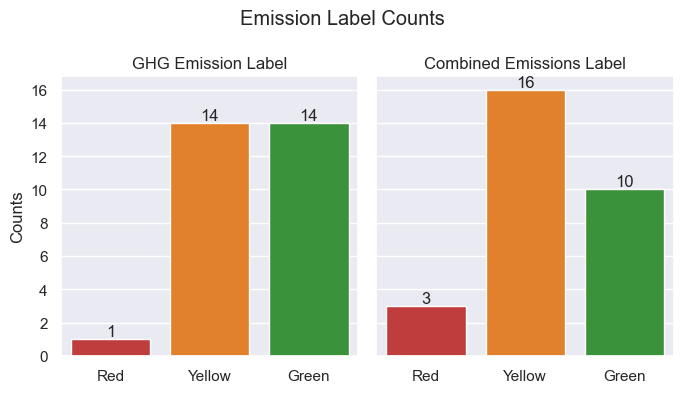

In [21]:
# THE BLUE BAR REPRESENTS THE SUM ROW WHICH IS THE TOTAL NUMBER OF RECIPES THAT HAVE BEEN ASSIGNED A LABEL
# EACH BAR REPRESENTS THE # OF RECIPES THAT WERE LABELLED WITH THAT SPECIFIC COLOUR

fig = create_visualizations(counts)
fig

In [22]:
final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,HARVEST Feastival 2024,None,R-73975,HARVEST Feastival 2024,FOOD,470.915000,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42,Yellow,Yellow
1,HARVEST,Cake,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,1.000000,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52,Yellow,Red
2,HARVEST,Cake,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,1.000000,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52,Yellow,Yellow
3,HARVEST,Muffin,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1110.545455,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47,Green,Yellow
4,HARVEST,Muffin,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1119.000000,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49,Green,Yellow


In [23]:
final3 = final2.drop(columns=['Category', 'Displayed Name', 'Weight (g)', 'GHG Only Label'])

In [24]:
final3.head()

,ProdId,Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-73975,HARVEST Feastival 2024,FOOD,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42,Yellow
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52,Red
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52,Yellow
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47,Yellow
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49,Yellow


In [25]:
final3.rename(columns={'ProdId': 'Optimum Control ID', 'Description': 'OC Description'}, inplace=True)

In [26]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-73975,HARVEST Feastival 2024,FOOD,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42,Yellow
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52,Red
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52,Yellow
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47,Yellow
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49,Yellow


In [27]:
final3['Red'] = final3['Combined Label'] == 'Red'
final3['Yellow'] = final3['Combined Label'] == 'Yellow'
final3['Green'] = final3['Combined Label'] == 'Green'

In [28]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Red,Yellow,Green
0,R-73975,HARVEST Feastival 2024,FOOD,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42,Yellow,False,True,False
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52,Red,True,False,False
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52,Yellow,False,True,False
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47,Yellow,False,True,False
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49,Yellow,False,True,False


In [29]:
import pandas as pd


desired_column_order = [
    'Optimum Control ID', 'OC Description', 'SalesGroup', 'Combined Label', 'Red', 'Yellow', 'Green',
    'GHG Emission (g)', 'N lost (g)', 'Land Use (m^2)', 'Freshwater Withdrawals (L)', 
    'Stress-Weighted Water Use (L)', 'GHG Emission (g) / 100g', 'N lost (g) / 100g', 
    'Freshwater Withdrawals (L) / 100g', 'Stress-Weighted Water Use (L) / 100g', 
    'Land Use (m^2) / 100g'
]

# Create a new DataFrame with the desired column order
data_reordered = final3[desired_column_order]

# Print the reordered DataFrame
data_reordered.head()


,Optimum Control ID,OC Description,SalesGroup,Combined Label,Red,Yellow,Green,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-73975,HARVEST Feastival 2024,FOOD,Yellow,False,True,False,1154.636046,13.748709,1.972337,280.73,4023.34,245.19,2.92,59.61,854.37,0.42
1,R-62876,HARVEST|Cake|Granola Bar 6ea,FOOD - BAKERY & DESSERTS,Red,True,False,False,2.546805,0.008008,0.005202,0.89,58.71,254.68,0.80,89.00,5871.00,0.52
2,R-33249,HARVEST|Cake|Ponderosa 6ea,FOOD - BAKERY & DESSERTS,Yellow,False,True,False,3.211837,0.023427,0.005180,0.29,14.28,321.18,2.34,29.00,1428.00,0.52
3,R-63503,HARVEST|Muffin|Carrot (6ea),FOOD - BAKERY & DESSERTS,Yellow,False,True,False,1725.180000,15.770455,5.232000,497.43,18256.02,155.35,1.42,44.79,1643.88,0.47
4,R-33289,HARVEST|Muffin|Fruit Med (6ea),FOOD - BAKERY & DESSERTS,Yellow,False,True,False,1708.568100,16.327500,5.479470,471.09,14479.97,152.69,1.46,42.10,1294.01,0.49


In [30]:
data_reordered.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Labelled_Data_"+restaurant_name+"_for_nutrislice.csv",
                  index=False)